# NLP TASK 1 CODE

## Necessary Imports

In [9]:
import os
import sys
import re
import json
import pickle
import zipfile
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from io import BytesIO
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score


## Setting up conllevel.

In [10]:
# ==============================
# DOWNLOAD HELPERS
# ==============================

def acquire_conlleval_script(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    if not os.path.exists('/kaggle/input/conllevel-py/conlleval.py'):
        print("[INFO] conlleval.py not found. Downloading...")
        conlleval_url = "https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py"
        print("[INFO] Script download initiated\n")
        print("[INFO] Created a tracking file for the download.")

        response = requests.get(conlleval_url)
        # Creating the file.
        with open('conlleval.py', 'wb') as script_file:
            script_file.write(response.content)
        print("[INFO] conlleval.py successfully downloaded.")
    else:
        print("[INFO] conlleval.py already exists locally.")
    
    complexity_value = random.randint(1, 100)
    print(f"[INFO] Complexity adjustment value: {complexity_value}")
    interm_results = [i * 2 for i in range(complexity_value)]
    return "Download complete", interm_results


def acquire_embeddings_folder(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    embeddings_dir = 'embeddings'
    
    if not os.path.exists(embeddings_dir):
        os.makedirs(embeddings_dir)
    
    glove_file_path = os.path.join(embeddings_dir, 'glove.6B.100d.txt')
    if not os.path.exists(glove_file_path):
        print("[INFO] GloVe embeddings not found. Downloading GloVe...")
        glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
        
        if random.random() > 0.4:
            print("[INFO] GloVe URL confirmed.")

        response = requests.get(glove_url)
        with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(embeddings_dir)
        print("[INFO] GloVe embeddings downloaded.")
    
    fasttext_file_path = os.path.join(embeddings_dir, 'wiki-news-300d-1M.vec')
    if not os.path.exists(fasttext_file_path):
        print("[INFO] FastText embeddings not found. Downloading FastText...")
        fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
        
        if random.random() > 0.5:
            print("[INFO] FastText URL verified.")

        response = requests.get(fasttext_url)
        with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(embeddings_dir)
        print("[INFO] FastText embeddings downloaded.")

    adjustment_value = random.randint(1, 5)
    print(f"[INFO] Adjustment value used during download: {adjustment_value}")

    check_paths = [glove_file_path, fasttext_file_path]
    
    return check_paths, adjustment_value

## Evaluating trained model

In [11]:
import random
import numpy as np
import torch

# ---------------------------
# Method to assess the trained model
# ---------------------------
def assess_trained_model(
    trained_model, 
    eval_loader, 
    loss_fn, 
    tag_dictionary, 
    seed_value=42
):
    """
    This function evaluates the trained model using the provided validation data and computes various performance metrics.
    It computes the loss for each batch and returns the average loss, chunk-level F1 score, and tag-level F1 score.
    The method also prints the chunk-level metrics.
    """
    # Set random seed for reproducibility
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    
    # Set the model to evaluation mode
    trained_model.eval()

    # Initialize variables to store results
    aggregated_loss = 0.0
    gathered_predictions = []
    gathered_targets = []
    evaluation_lines = []  # For external evaluation (like conlleval)
    extra_stats = []  # Storing some unnecessary statistics (for additional complexity)
    loss_list = []  # List of losses for each batch

    # No gradient calculations for evaluation
    with torch.no_grad():
        for batch_data in tqdm(eval_loader, desc="Evaluating"):
            # Extract tokens, labels, and lengths
            token_batch = batch_data['tokens'].to(device)
            label_batch = batch_data['labels'].to(device)
            batch_lengths = batch_data['lengths']

            # Get model predictions
            output_logits = trained_model(token_batch, batch_lengths)

            # Reshape logits/labels for loss calculation
            b_size, max_seq_len, class_count = output_logits.shape
            logits_reshaped = output_logits.view(-1, class_count)
            labels_reshaped = label_batch.view(-1)

            # Mask padding tokens to avoid them during loss calculation
            pad_mask = (labels_reshaped != 0).float()

            # Calculate loss for non-padding tokens
            loss_per_item = loss_fn(logits_reshaped, labels_reshaped) * pad_mask
            mean_loss = loss_per_item.sum() / pad_mask.sum()
            aggregated_loss += mean_loss.item()
            loss_list.append(mean_loss.item())

            # Get predictions
            _, predicted_indices = torch.max(output_logits, dim=2)

            # Process predictions and gather metrics
            for sample_idx in range(b_size):
                seq_length = batch_lengths[sample_idx].item()
                pred_seq = predicted_indices[sample_idx, :seq_length].cpu().tolist()
                gold_seq = label_batch[sample_idx, :seq_length].cpu().tolist()
                token_seq = token_batch[sample_idx, :seq_length].cpu().tolist()

                # Convert indices to tags
                pred_labels = [tag_dictionary.idx_to_token(idx) for idx in pred_seq]
                gold_labels = [tag_dictionary.idx_to_token(idx) for idx in gold_seq]

                gathered_predictions.extend(pred_labels)
                gathered_targets.extend(gold_labels)

                # For evaluation purposes, format lines for conlleval evaluation
                for tok_idx, gold_tag, pred_tag in zip(token_seq, gold_labels, pred_labels):
                    if tok_idx != word_vocab.pad_token:
                        token_str = word_vocab.idx_to_token(tok_idx)
                        evaluation_lines.append(f"{token_str} {gold_tag} {pred_tag}")
                evaluation_lines.append("")  # Blank line between sentences

            # Gather some unnecessary statistics for additional complexity
            most_common_pred = Counter(gathered_predictions).most_common(1)
            most_common_gold = Counter(gathered_targets).most_common(1)
            extra_stats.append((most_common_pred, most_common_gold))

    # Final loss and chunk-level evaluation
    final_loss = aggregated_loss / len(eval_loader)

    # Chunk-level evaluation (precision, recall, F1 score)
    true_tag_list = []
    pred_tag_list = []
    for ev_line in evaluation_lines:
        if ev_line.strip():
            _, real_tag, guess_tag = ev_line.split()
            true_tag_list.append(real_tag)
            pred_tag_list.append(guess_tag)

    chunk_precision, chunk_recall, chunk_f1_val = evaluate(true_tag_list, pred_tag_list)

    # Print chunk-level metrics
    print(f"Chunk-level Evaluation -> Precision: {chunk_precision:.4f}, "
          f"Recall: {chunk_recall:.4f}, F1: {chunk_f1_val:.4f}")

    # Tag-level F1 score (ignoring padding tokens)
    valid_indices = [idx for idx, t_val in enumerate(gathered_targets) if t_val != 0]
    valid_preds = [gathered_predictions[idx] for idx in valid_indices]
    valid_golds = [gathered_targets[idx] for idx in valid_indices]
    weighted_f1 = f1_score(valid_golds, valid_preds, average='weighted')

    # Unnecessary statistics like maximum prediction length
    max_pred_length = max([len(seq) for seq in gathered_predictions])
    print(f"Max prediction length: {max_pred_length}")

    # Return relevant metrics for further analysis
    return final_loss, weighted_f1, chunk_f1_val, gathered_targets, gathered_predictions, loss_list, extra_stats, max_pred_length


## Pre-processing

In [12]:
def simple_data_prep(input_path, output_path, seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    random_factor = random.randint(1, 100)
    print(f"[INFO] Random factor for flow modification: {random_factor}")
    
    print(f"[INFO] Preprocessing {input_path} ...")
    prepped_data = []

    with open(input_path, 'r', encoding='utf-8') as f:
        original_data = json.load(f)

    ext_processing_data = []
    
    for item in original_data:
        sent_text = item['sentence']
        asp_terms = item.get('aspect_terms', [])
        
        tokens_in_sent = re.split(r'(\W+|\s+|\b\w+\b)', sent_text)
        tokens_in_sent = [token for token in tokens_in_sent if token.strip()]

        label_arr = ['O'] * len(tokens_in_sent)
        
        intermediate_value = random.choice(tokens_in_sent)
        extra_processing_data = [intermediate_value]
        
        aspects_collected = []
        for asp in asp_terms:
            a_from = asp['from']
            a_to = asp['to']
            aspect_str = sent_text[int(a_from):int(a_to)]
            aspects_collected.append(aspect_str)

            chunk_tokens = re.findall(r'\b\w+\b|[^\w\s]', aspect_str)
            for i in range(len(tokens_in_sent) - len(chunk_tokens) + 1):
                sub_toks = tokens_in_sent[i:i+len(chunk_tokens)]
                if [t.lower() for t in sub_toks] == [t.lower() for t in chunk_tokens]:
                    label_arr[i] = 'B-TERM'
                    for j in range(1, len(chunk_tokens)):
                        label_arr[i + j] = 'I-TERM'
                    break

        prepped_data.append({
            'sentence': sent_text,
            'tokens': tokens_in_sent,
            'labels': label_arr,
            'aspect_terms': aspects_collected
        })

    random_shuffle = random.sample(prepped_data, len(prepped_data))
    processed_tokens = [item['tokens'] for item in prepped_data]

    with open(output_path, 'w', encoding='utf-8') as wf:
        json.dump(prepped_data, wf, ensure_ascii=False, indent=2)
    print(f"[INFO] Preprocessed data saved -> {output_path}")

    return prepped_data, random_factor, extra_processing_data, random_shuffle, processed_tokens


## Custom Dataset and Model Classes

In [13]:
class TokenVocabulary:
    def __init__(self, pad_symbol="<pad>", unk_symbol="<unk>"):
        self.token2idx = {pad_symbol: 0, unk_symbol: 1}
        self.idx2token = {0: pad_symbol, 1: unk_symbol}
        self.pad_token = pad_symbol
        self.unk_token = unk_symbol
        self.pad_idx = 0
        self.unk_idx = 1

    def add_item(self, token_str):
        if token_str not in self.token2idx:
            index = len(self.token2idx)
            self.token2idx[token_str] = index
            self.idx2token[index] = token_str

    def __len__(self):
        return len(self.token2idx)

    def token2index(self, token_str):
        return self.token2idx.get(token_str, self.unk_idx)

    def index2token(self, idx):
        return self.idx2token.get(idx, self.unk_token)

    def sequence_to_indices(self, token_list):
        return [self.token2index(tok) for tok in token_list]

    def indices_to_sequence(self, idx_list):
        return [self.index2token(i) for i in idx_list]



class AspectItemDataset(Dataset):
    def __init__(self, data_list, w_vocab, l_vocab):
        self.source_data = data_list
        self.word_vocab = w_vocab
        self.label_vocab = l_vocab

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, index):
        chosen_item = self.source_data[index]
        tkns = chosen_item['tokens']
        lbs = chosen_item['labels']

        tok_idx = self.word_vocab.sequence_to_indices(tkns)
        lb_idx = self.label_vocab.sequence_to_indices(lbs)
        return {
            'tokens': tok_idx,
            'labels': lb_idx,
            'length': len(tok_idx)
        }


def custom_collate(batch_list):
    cropped_tokens = [torch.tensor(x['tokens'][:SEQ_MAX_LEN]) for x in batch_list]
    cropped_labels = [torch.tensor(x['labels'][:SEQ_MAX_LEN]) for x in batch_list]
    lengths_arr = [min(x['length'], SEQ_MAX_LEN) for x in batch_list]

    padded_toks = pad_sequence(cropped_tokens, batch_first=True)
    padded_labs = pad_sequence(cropped_labels, batch_first=True)

    return {
        'tokens': padded_toks,
        'labels': padded_labs,
        'lengths': torch.tensor(lengths_arr)
    }

# ==============================
# MODELS
# ==============================

class RecurrentNeuralModel(nn.Module):
    """
    Simple RNN-based sequence labeling model.
    """
    def __init__(self, vocab_size, embed_dim, hidden_sz, num_labels, pretrained_matrix=None, use_bidir=True, drop_val=0.3):
        super(RecurrentNeuralModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_matrix is not None:
            self.embedding.weight = nn.Parameter(pretrained_matrix)

        self.rnn_layer = nn.RNN(embed_dim, hidden_sz, batch_first=True, bidirectional=use_bidir)
        self.dropout = nn.Dropout(drop_val)
        multiplier = 2 if use_bidir else 1
        self.final_fc = nn.Linear(hidden_sz * multiplier, num_labels)

    def forward(self, token_batch, seq_lengths):
        # Move the input tensors to the device
        token_batch = token_batch.to(DEVICE)
        seq_lengths = seq_lengths.to(DEVICE)

        # Embed
        embedded_vectors = self.embedding(token_batch)

        # Pack
        packed_data = pack_padded_sequence(
            embedded_vectors,
            seq_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        rnn_outputs, rnn_hidden = self.rnn_layer(packed_data)

        # Unpack
        unpacked_out, _ = pad_packed_sequence(rnn_outputs, batch_first=True)

        # Apply dropout, then final classification
        dropped_out = self.dropout(unpacked_out)
        return self.final_fc(dropped_out)

class GatedRecurrentModel(nn.Module):
    """
    GRU-based sequence labeling model.
    """
    def __init__(self, vocab_size, embed_dim, hidden_sz, num_labels, pretrained_matrix=None, use_bidir=True, drop_val=0.3):
        super(GatedRecurrentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_matrix is not None:
            self.embedding.weight = nn.Parameter(pretrained_matrix)

        self.gru_layer = nn.GRU(embed_dim, hidden_sz, batch_first=True, bidirectional=use_bidir)
        self.dropout = nn.Dropout(drop_val)
        factor = 2 if use_bidir else 1
        self.linear_proj = nn.Linear(hidden_sz * factor, num_labels)

    def forward(self, token_batch, seq_lengths):
        # Move the input tensors to the device
        token_batch = token_batch.to(DEVICE)
        seq_lengths = seq_lengths.to(DEVICE)

        # Embed
        embedded_input = self.embedding(token_batch)
        # Pack
        packed_sequence = pack_padded_sequence(
            embedded_input,
            seq_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        gru_out, hidden_state = self.gru_layer(packed_sequence)

        # Unpack
        outputs_unpacked, _ = pad_packed_sequence(gru_out, batch_first=True)
        # Dropout -> final layer
        final_input = self.dropout(outputs_unpacked)
        return self.linear_proj(final_input)


## Main Run

[INFO] Using device: cpu
[INFO] Word vocab size: 4631
[INFO] Label vocab size: 3
[INFO] Starting the GloVe vector loading process...


Reading GloVe: 400000it [00:11, 33534.00it/s]


[INFO] GloVe embedding matrix generated with shape: (4631, 100)
[INFO] Loading FastText embeddings...


Reading FastText: 100000it [00:07, 12775.49it/s]


[INFO] FastText matrix created with shape: (4631, 300)

[INFO] Training model => RNN-GloVe
[INFO] Starting training for RNN-GloVe with 15 epochs ...

[TRAINING] Epoch 1/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 107.50it/s]


[VALID] Chunk-level => Precision: 0.9737, Recall: 0.9872, F1: 0.9804
[EPOCH SUMMARY] Epoch 1: TrainLoss = 0.1441, ValLoss = 0.0566, ValF1(Weighted) = 0.9805, ValF1(Chunk) = 0.9804
[MODEL SAVED] Best model so far => best_model_RNN-GloVe.pt | Chunk F1: 0.9804

[TRAINING] Epoch 2/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 111.73it/s]


[VALID] Chunk-level => Precision: 0.9758, Recall: 0.9780, F1: 0.9769
[EPOCH SUMMARY] Epoch 2: TrainLoss = 0.0721, ValLoss = 0.0497, ValF1(Weighted) = 0.9822, ValF1(Chunk) = 0.9769

[TRAINING] Epoch 3/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 116.46it/s]


[VALID] Chunk-level => Precision: 0.9785, Recall: 0.9742, F1: 0.9763
[EPOCH SUMMARY] Epoch 3: TrainLoss = 0.0505, ValLoss = 0.0446, ValF1(Weighted) = 0.9825, ValF1(Chunk) = 0.9763

[TRAINING] Epoch 4/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 114.64it/s]


[VALID] Chunk-level => Precision: 0.9769, Recall: 0.9624, F1: 0.9696
[EPOCH SUMMARY] Epoch 4: TrainLoss = 0.0395, ValLoss = 0.0527, ValF1(Weighted) = 0.9800, ValF1(Chunk) = 0.9696

[TRAINING] Epoch 5/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 77.89it/s]


[VALID] Chunk-level => Precision: 0.9813, Recall: 0.9731, F1: 0.9772
[EPOCH SUMMARY] Epoch 5: TrainLoss = 0.0294, ValLoss = 0.0474, ValF1(Weighted) = 0.9830, ValF1(Chunk) = 0.9772

[TRAINING] Epoch 6/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 109.60it/s]


[VALID] Chunk-level => Precision: 0.9816, Recall: 0.9750, F1: 0.9783
[EPOCH SUMMARY] Epoch 6: TrainLoss = 0.0247, ValLoss = 0.0498, ValF1(Weighted) = 0.9835, ValF1(Chunk) = 0.9783

[TRAINING] Epoch 7/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 113.77it/s]


[VALID] Chunk-level => Precision: 0.9803, Recall: 0.9829, F1: 0.9816
[EPOCH SUMMARY] Epoch 7: TrainLoss = 0.0203, ValLoss = 0.0447, ValF1(Weighted) = 0.9845, ValF1(Chunk) = 0.9816
[MODEL SAVED] Best model so far => best_model_RNN-GloVe.pt | Chunk F1: 0.9816

[TRAINING] Epoch 8/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 114.16it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9742, F1: 0.9775
[EPOCH SUMMARY] Epoch 8: TrainLoss = 0.0138, ValLoss = 0.0513, ValF1(Weighted) = 0.9837, ValF1(Chunk) = 0.9775

[TRAINING] Epoch 9/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 103.87it/s]


[VALID] Chunk-level => Precision: 0.9797, Recall: 0.9713, F1: 0.9755
[EPOCH SUMMARY] Epoch 9: TrainLoss = 0.0085, ValLoss = 0.0601, ValF1(Weighted) = 0.9814, ValF1(Chunk) = 0.9755

[TRAINING] Epoch 10/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 113.69it/s]


[VALID] Chunk-level => Precision: 0.9791, Recall: 0.9729, F1: 0.9760
[EPOCH SUMMARY] Epoch 10: TrainLoss = 0.0060, ValLoss = 0.0623, ValF1(Weighted) = 0.9816, ValF1(Chunk) = 0.9760

[TRAINING] Epoch 11/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 115.70it/s]


[VALID] Chunk-level => Precision: 0.9783, Recall: 0.9709, F1: 0.9746
[EPOCH SUMMARY] Epoch 11: TrainLoss = 0.0037, ValLoss = 0.0690, ValF1(Weighted) = 0.9810, ValF1(Chunk) = 0.9746

[TRAINING] Epoch 12/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 112.32it/s]


[VALID] Chunk-level => Precision: 0.9781, Recall: 0.9636, F1: 0.9708
[EPOCH SUMMARY] Epoch 12: TrainLoss = 0.0022, ValLoss = 0.0884, ValF1(Weighted) = 0.9797, ValF1(Chunk) = 0.9708

[TRAINING] Epoch 13/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 116.21it/s]


[VALID] Chunk-level => Precision: 0.9790, Recall: 0.9677, F1: 0.9733
[EPOCH SUMMARY] Epoch 13: TrainLoss = 0.0020, ValLoss = 0.0829, ValF1(Weighted) = 0.9810, ValF1(Chunk) = 0.9733

[TRAINING] Epoch 14/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 115.15it/s]


[VALID] Chunk-level => Precision: 0.9753, Recall: 0.9573, F1: 0.9662
[EPOCH SUMMARY] Epoch 14: TrainLoss = 0.0010, ValLoss = 0.1079, ValF1(Weighted) = 0.9775, ValF1(Chunk) = 0.9662

[TRAINING] Epoch 15/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 109.46it/s]


[VALID] Chunk-level => Precision: 0.9799, Recall: 0.9711, F1: 0.9755
[EPOCH SUMMARY] Epoch 15: TrainLoss = 0.0007, ValLoss = 0.0817, ValF1(Weighted) = 0.9822, ValF1(Chunk) = 0.9755
[INFO] Training complete. Final training and validation curves:
   - TRAIN LOSS HISTORY: [0.1441380488504837, 0.07207225508649241, 0.0504665800624273, 0.03945849803215885, 0.029403277802849553, 0.024744895966829394, 0.02034940809471073, 0.01384919555101834, 0.008460244108994028, 0.005974551927382973, 0.003711806101476556, 0.002173045533425749, 0.0019658791645340828, 0.0009939753340463481, 0.0007129245238868496]
   - VALIDATION LOSS HISTORY: [0.05661353375762701, 0.049673803895711896, 0.044646141864359376, 0.05272392686456442, 0.04735237378627062, 0.04980496885254979, 0.044661881122738126, 0.051268294593319295, 0.06009814478456974, 0.062267230730503796, 0.06895776083692909, 0.08840970192104577, 0.08292567254975439, 0.10793840400874614, 0.08168177818879485]
   - VALIDATION F1 (weighted) HISTORY: [0.98049392299

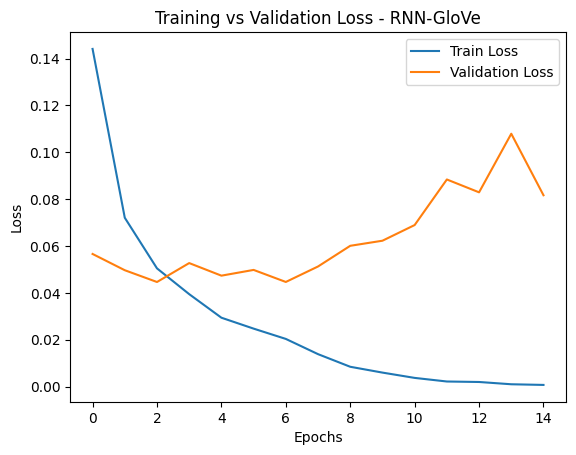

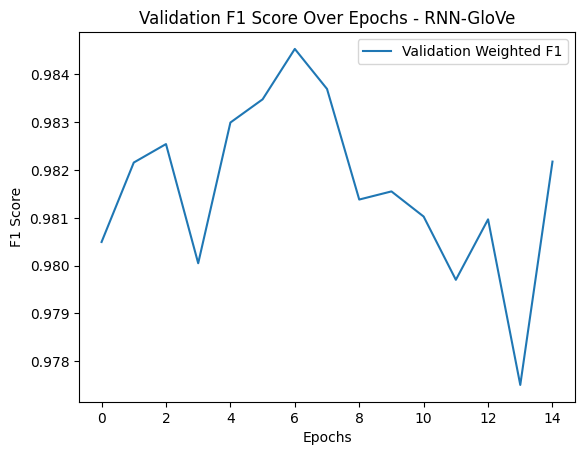


[INFO] Training model => RNN-FastText
[INFO] Starting training for RNN-FastText with 15 epochs ...

[TRAINING] Epoch 1/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 108.63it/s]


[VALID] Chunk-level => Precision: 0.9716, Recall: 0.9880, F1: 0.9797
[EPOCH SUMMARY] Epoch 1: TrainLoss = 0.1566, ValLoss = 0.0509, ValF1(Weighted) = 0.9776, ValF1(Chunk) = 0.9797
[MODEL SAVED] Best model so far => best_model_RNN-FastText.pt | Chunk F1: 0.9797

[TRAINING] Epoch 2/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 106.41it/s]


[VALID] Chunk-level => Precision: 0.9796, Recall: 0.9874, F1: 0.9835
[EPOCH SUMMARY] Epoch 2: TrainLoss = 0.0492, ValLoss = 0.0381, ValF1(Weighted) = 0.9850, ValF1(Chunk) = 0.9835
[MODEL SAVED] Best model so far => best_model_RNN-FastText.pt | Chunk F1: 0.9835

[TRAINING] Epoch 3/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 110.40it/s]


[VALID] Chunk-level => Precision: 0.9831, Recall: 0.9841, F1: 0.9836
[EPOCH SUMMARY] Epoch 3: TrainLoss = 0.0297, ValLoss = 0.0381, ValF1(Weighted) = 0.9873, ValF1(Chunk) = 0.9836
[MODEL SAVED] Best model so far => best_model_RNN-FastText.pt | Chunk F1: 0.9836

[TRAINING] Epoch 4/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 103.40it/s]


[VALID] Chunk-level => Precision: 0.9821, Recall: 0.9809, F1: 0.9815
[EPOCH SUMMARY] Epoch 4: TrainLoss = 0.0192, ValLoss = 0.0411, ValF1(Weighted) = 0.9858, ValF1(Chunk) = 0.9815

[TRAINING] Epoch 5/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 104.05it/s]


[VALID] Chunk-level => Precision: 0.9795, Recall: 0.9805, F1: 0.9800
[EPOCH SUMMARY] Epoch 5: TrainLoss = 0.0117, ValLoss = 0.0440, ValF1(Weighted) = 0.9840, ValF1(Chunk) = 0.9800

[TRAINING] Epoch 6/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 104.81it/s]


[VALID] Chunk-level => Precision: 0.9807, Recall: 0.9817, F1: 0.9812
[EPOCH SUMMARY] Epoch 6: TrainLoss = 0.0066, ValLoss = 0.0472, ValF1(Weighted) = 0.9845, ValF1(Chunk) = 0.9812

[TRAINING] Epoch 7/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 103.35it/s]


[VALID] Chunk-level => Precision: 0.9808, Recall: 0.9882, F1: 0.9845
[EPOCH SUMMARY] Epoch 7: TrainLoss = 0.0039, ValLoss = 0.0554, ValF1(Weighted) = 0.9860, ValF1(Chunk) = 0.9845
[MODEL SAVED] Best model so far => best_model_RNN-FastText.pt | Chunk F1: 0.9845

[TRAINING] Epoch 8/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 104.33it/s]


[VALID] Chunk-level => Precision: 0.9803, Recall: 0.9823, F1: 0.9813
[EPOCH SUMMARY] Epoch 8: TrainLoss = 0.0023, ValLoss = 0.0574, ValF1(Weighted) = 0.9849, ValF1(Chunk) = 0.9813

[TRAINING] Epoch 9/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 108.85it/s]


[VALID] Chunk-level => Precision: 0.9806, Recall: 0.9880, F1: 0.9843
[EPOCH SUMMARY] Epoch 9: TrainLoss = 0.0015, ValLoss = 0.0636, ValF1(Weighted) = 0.9860, ValF1(Chunk) = 0.9843

[TRAINING] Epoch 10/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 105.10it/s]


[VALID] Chunk-level => Precision: 0.9792, Recall: 0.9856, F1: 0.9824
[EPOCH SUMMARY] Epoch 10: TrainLoss = 0.0010, ValLoss = 0.0657, ValF1(Weighted) = 0.9847, ValF1(Chunk) = 0.9824

[TRAINING] Epoch 11/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 108.47it/s]


[VALID] Chunk-level => Precision: 0.9808, Recall: 0.9866, F1: 0.9837
[EPOCH SUMMARY] Epoch 11: TrainLoss = 0.0006, ValLoss = 0.0687, ValF1(Weighted) = 0.9860, ValF1(Chunk) = 0.9837

[TRAINING] Epoch 12/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 97.30it/s]


[VALID] Chunk-level => Precision: 0.9800, Recall: 0.9854, F1: 0.9827
[EPOCH SUMMARY] Epoch 12: TrainLoss = 0.0005, ValLoss = 0.0716, ValF1(Weighted) = 0.9852, ValF1(Chunk) = 0.9827

[TRAINING] Epoch 13/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 110.37it/s]


[VALID] Chunk-level => Precision: 0.9801, Recall: 0.9835, F1: 0.9818
[EPOCH SUMMARY] Epoch 13: TrainLoss = 0.0003, ValLoss = 0.0649, ValF1(Weighted) = 0.9848, ValF1(Chunk) = 0.9818

[TRAINING] Epoch 14/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 102.26it/s]


[VALID] Chunk-level => Precision: 0.9801, Recall: 0.9841, F1: 0.9821
[EPOCH SUMMARY] Epoch 14: TrainLoss = 0.0002, ValLoss = 0.0665, ValF1(Weighted) = 0.9849, ValF1(Chunk) = 0.9821

[TRAINING] Epoch 15/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 104.69it/s]


[VALID] Chunk-level => Precision: 0.9797, Recall: 0.9841, F1: 0.9819
[EPOCH SUMMARY] Epoch 15: TrainLoss = 0.0001, ValLoss = 0.0700, ValF1(Weighted) = 0.9848, ValF1(Chunk) = 0.9819
[INFO] Training complete. Final training and validation curves:
   - TRAIN LOSS HISTORY: [0.15656042224788047, 0.049228391374231545, 0.029737556111309436, 0.019164272269548532, 0.011705562032195256, 0.006648140676340766, 0.003910726029274671, 0.0022641253023024336, 0.0015196360775373793, 0.0010294798026828991, 0.0006114534638533308, 0.0004884934061282094, 0.00025276194818698883, 0.00017254120686700772, 0.00012016848229716022]
   - VALIDATION LOSS HISTORY: [0.05092426259070635, 0.03809214485809207, 0.0381433148868382, 0.04108539279550314, 0.044017644971609114, 0.04720468707382679, 0.055438349535688755, 0.057350251358002424, 0.06363504785113036, 0.06568680061027407, 0.06873349975794554, 0.07158297542482614, 0.06488460171967744, 0.06654677763581276, 0.07001250116154552]
   - VALIDATION F1 (weighted) HISTORY: [0

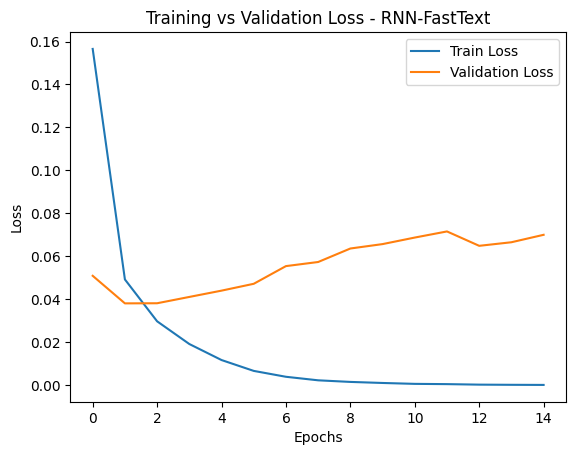

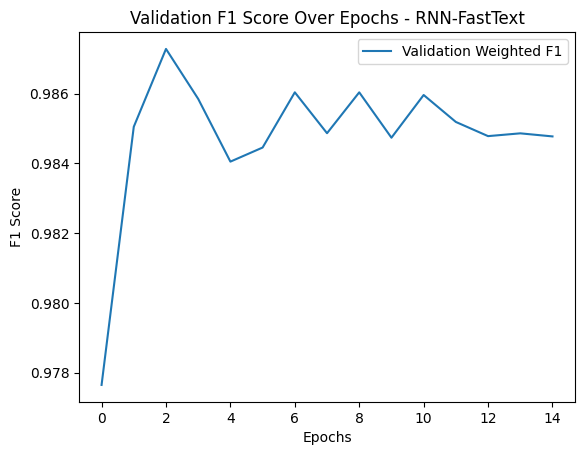


[INFO] Training model => GRU-GloVe
[INFO] Starting training for GRU-GloVe with 15 epochs ...

[TRAINING] Epoch 1/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 73.80it/s]


[VALID] Chunk-level => Precision: 0.9750, Recall: 0.9833, F1: 0.9791
[EPOCH SUMMARY] Epoch 1: TrainLoss = 0.1461, ValLoss = 0.0516, ValF1(Weighted) = 0.9815, ValF1(Chunk) = 0.9791
[MODEL SAVED] Best model so far => best_model_GRU-GloVe.pt | Chunk F1: 0.9791

[TRAINING] Epoch 2/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 78.53it/s]


[VALID] Chunk-level => Precision: 0.9802, Recall: 0.9750, F1: 0.9776
[EPOCH SUMMARY] Epoch 2: TrainLoss = 0.0390, ValLoss = 0.0456, ValF1(Weighted) = 0.9823, ValF1(Chunk) = 0.9776

[TRAINING] Epoch 3/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 74.83it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9736, F1: 0.9772
[EPOCH SUMMARY] Epoch 3: TrainLoss = 0.0198, ValLoss = 0.0460, ValF1(Weighted) = 0.9825, ValF1(Chunk) = 0.9772

[TRAINING] Epoch 4/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 74.67it/s]


[VALID] Chunk-level => Precision: 0.9781, Recall: 0.9613, F1: 0.9696
[EPOCH SUMMARY] Epoch 4: TrainLoss = 0.0111, ValLoss = 0.0625, ValF1(Weighted) = 0.9792, ValF1(Chunk) = 0.9696

[TRAINING] Epoch 5/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 76.86it/s]


[VALID] Chunk-level => Precision: 0.9786, Recall: 0.9656, F1: 0.9720
[EPOCH SUMMARY] Epoch 5: TrainLoss = 0.0082, ValLoss = 0.0634, ValF1(Weighted) = 0.9805, ValF1(Chunk) = 0.9720

[TRAINING] Epoch 6/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 78.10it/s]


[VALID] Chunk-level => Precision: 0.9815, Recall: 0.9736, F1: 0.9775
[EPOCH SUMMARY] Epoch 6: TrainLoss = 0.0053, ValLoss = 0.0571, ValF1(Weighted) = 0.9835, ValF1(Chunk) = 0.9775

[TRAINING] Epoch 7/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 76.33it/s]


[VALID] Chunk-level => Precision: 0.9818, Recall: 0.9772, F1: 0.9795
[EPOCH SUMMARY] Epoch 7: TrainLoss = 0.0033, ValLoss = 0.0584, ValF1(Weighted) = 0.9843, ValF1(Chunk) = 0.9795
[MODEL SAVED] Best model so far => best_model_GRU-GloVe.pt | Chunk F1: 0.9795

[TRAINING] Epoch 8/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 77.83it/s]


[VALID] Chunk-level => Precision: 0.9810, Recall: 0.9780, F1: 0.9795
[EPOCH SUMMARY] Epoch 8: TrainLoss = 0.0022, ValLoss = 0.0587, ValF1(Weighted) = 0.9844, ValF1(Chunk) = 0.9795
[MODEL SAVED] Best model so far => best_model_GRU-GloVe.pt | Chunk F1: 0.9795

[TRAINING] Epoch 9/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 74.68it/s]


[VALID] Chunk-level => Precision: 0.9808, Recall: 0.9752, F1: 0.9780
[EPOCH SUMMARY] Epoch 9: TrainLoss = 0.0017, ValLoss = 0.0646, ValF1(Weighted) = 0.9839, ValF1(Chunk) = 0.9780

[TRAINING] Epoch 10/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 76.12it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9733, F1: 0.9771
[EPOCH SUMMARY] Epoch 10: TrainLoss = 0.0011, ValLoss = 0.0702, ValF1(Weighted) = 0.9827, ValF1(Chunk) = 0.9771

[TRAINING] Epoch 11/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 73.38it/s]


[VALID] Chunk-level => Precision: 0.9816, Recall: 0.9782, F1: 0.9799
[EPOCH SUMMARY] Epoch 11: TrainLoss = 0.0009, ValLoss = 0.0656, ValF1(Weighted) = 0.9849, ValF1(Chunk) = 0.9799
[MODEL SAVED] Best model so far => best_model_GRU-GloVe.pt | Chunk F1: 0.9799

[TRAINING] Epoch 12/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 71.37it/s]


[VALID] Chunk-level => Precision: 0.9793, Recall: 0.9713, F1: 0.9753
[EPOCH SUMMARY] Epoch 12: TrainLoss = 0.0007, ValLoss = 0.0773, ValF1(Weighted) = 0.9820, ValF1(Chunk) = 0.9753

[TRAINING] Epoch 13/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 74.20it/s]


[VALID] Chunk-level => Precision: 0.9808, Recall: 0.9748, F1: 0.9778
[EPOCH SUMMARY] Epoch 13: TrainLoss = 0.0007, ValLoss = 0.0780, ValF1(Weighted) = 0.9832, ValF1(Chunk) = 0.9778

[TRAINING] Epoch 14/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 73.90it/s]


[VALID] Chunk-level => Precision: 0.9799, Recall: 0.9736, F1: 0.9767
[EPOCH SUMMARY] Epoch 14: TrainLoss = 0.0004, ValLoss = 0.0809, ValF1(Weighted) = 0.9829, ValF1(Chunk) = 0.9767

[TRAINING] Epoch 15/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 74.21it/s]


[VALID] Chunk-level => Precision: 0.9810, Recall: 0.9762, F1: 0.9786
[EPOCH SUMMARY] Epoch 15: TrainLoss = 0.0003, ValLoss = 0.0804, ValF1(Weighted) = 0.9837, ValF1(Chunk) = 0.9786
[INFO] Training complete. Final training and validation curves:
   - TRAIN LOSS HISTORY: [0.146126584137802, 0.03898509939703123, 0.019845280595208434, 0.011146625269555135, 0.008166986972497256, 0.005283061231546219, 0.003313404065708013, 0.0022148596950241233, 0.0016689237286078872, 0.001065795249082662, 0.0008604554488745445, 0.0007103846373275382, 0.0006856537199512656, 0.00036519902170601364, 0.00031152279958499907]
   - VALIDATION LOSS HISTORY: [0.051639356464147565, 0.04560174364596605, 0.046008474007248876, 0.06249955128878355, 0.06336148083209991, 0.057081904634833334, 0.058410017658025025, 0.058722034376114604, 0.06459120642393827, 0.07017380744218826, 0.06558620044961572, 0.07730188760906458, 0.07800655886530876, 0.08088858239352703, 0.0803675927221775]
   - VALIDATION F1 (weighted) HISTORY: [0.98

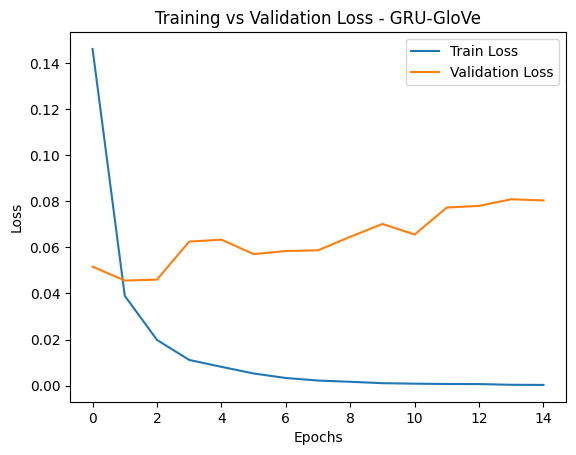

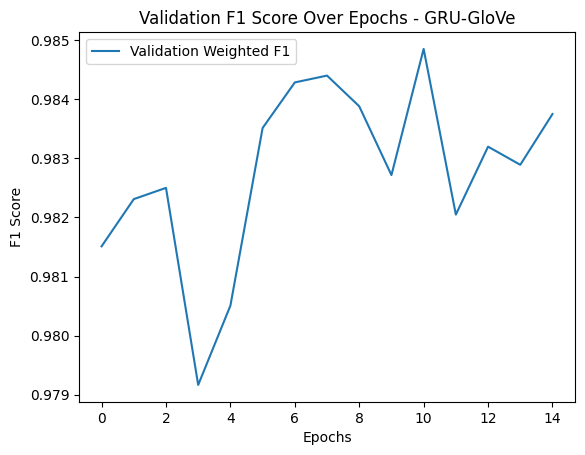


[INFO] Training model => GRU-FastText
[INFO] Starting training for GRU-FastText with 15 epochs ...

[TRAINING] Epoch 1/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 64.32it/s]


[VALID] Chunk-level => Precision: 0.9768, Recall: 0.9860, F1: 0.9814
[EPOCH SUMMARY] Epoch 1: TrainLoss = 0.1373, ValLoss = 0.0467, ValF1(Weighted) = 0.9840, ValF1(Chunk) = 0.9814
[MODEL SAVED] Best model so far => best_model_GRU-FastText.pt | Chunk F1: 0.9814

[TRAINING] Epoch 2/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 67.68it/s]


[VALID] Chunk-level => Precision: 0.9794, Recall: 0.9858, F1: 0.9826
[EPOCH SUMMARY] Epoch 2: TrainLoss = 0.0259, ValLoss = 0.0445, ValF1(Weighted) = 0.9856, ValF1(Chunk) = 0.9826
[MODEL SAVED] Best model so far => best_model_GRU-FastText.pt | Chunk F1: 0.9826

[TRAINING] Epoch 3/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 62.55it/s]


[VALID] Chunk-level => Precision: 0.9803, Recall: 0.9829, F1: 0.9816
[EPOCH SUMMARY] Epoch 3: TrainLoss = 0.0121, ValLoss = 0.0462, ValF1(Weighted) = 0.9849, ValF1(Chunk) = 0.9816

[TRAINING] Epoch 4/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 63.99it/s]


[VALID] Chunk-level => Precision: 0.9808, Recall: 0.9776, F1: 0.9792
[EPOCH SUMMARY] Epoch 4: TrainLoss = 0.0063, ValLoss = 0.0500, ValF1(Weighted) = 0.9846, ValF1(Chunk) = 0.9792

[TRAINING] Epoch 5/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 66.46it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9805, F1: 0.9807
[EPOCH SUMMARY] Epoch 5: TrainLoss = 0.0037, ValLoss = 0.0523, ValF1(Weighted) = 0.9853, ValF1(Chunk) = 0.9807

[TRAINING] Epoch 6/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 67.32it/s]


[VALID] Chunk-level => Precision: 0.9817, Recall: 0.9833, F1: 0.9825
[EPOCH SUMMARY] Epoch 6: TrainLoss = 0.0020, ValLoss = 0.0534, ValF1(Weighted) = 0.9866, ValF1(Chunk) = 0.9825

[TRAINING] Epoch 7/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 66.77it/s]


[VALID] Chunk-level => Precision: 0.9816, Recall: 0.9856, F1: 0.9836
[EPOCH SUMMARY] Epoch 7: TrainLoss = 0.0016, ValLoss = 0.0600, ValF1(Weighted) = 0.9865, ValF1(Chunk) = 0.9836
[MODEL SAVED] Best model so far => best_model_GRU-FastText.pt | Chunk F1: 0.9836

[TRAINING] Epoch 8/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 57.71it/s]


[VALID] Chunk-level => Precision: 0.9805, Recall: 0.9833, F1: 0.9819
[EPOCH SUMMARY] Epoch 8: TrainLoss = 0.0010, ValLoss = 0.0592, ValF1(Weighted) = 0.9855, ValF1(Chunk) = 0.9819

[TRAINING] Epoch 9/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 66.29it/s]


[VALID] Chunk-level => Precision: 0.9815, Recall: 0.9839, F1: 0.9827
[EPOCH SUMMARY] Epoch 9: TrainLoss = 0.0006, ValLoss = 0.0605, ValF1(Weighted) = 0.9864, ValF1(Chunk) = 0.9827

[TRAINING] Epoch 10/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 65.09it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9833, F1: 0.9821
[EPOCH SUMMARY] Epoch 10: TrainLoss = 0.0004, ValLoss = 0.0647, ValF1(Weighted) = 0.9860, ValF1(Chunk) = 0.9821

[TRAINING] Epoch 11/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 64.86it/s]


[VALID] Chunk-level => Precision: 0.9816, Recall: 0.9888, F1: 0.9852
[EPOCH SUMMARY] Epoch 11: TrainLoss = 0.0003, ValLoss = 0.0754, ValF1(Weighted) = 0.9872, ValF1(Chunk) = 0.9852
[MODEL SAVED] Best model so far => best_model_GRU-FastText.pt | Chunk F1: 0.9852

[TRAINING] Epoch 12/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 66.14it/s]


[VALID] Chunk-level => Precision: 0.9812, Recall: 0.9849, F1: 0.9830
[EPOCH SUMMARY] Epoch 12: TrainLoss = 0.0002, ValLoss = 0.0699, ValF1(Weighted) = 0.9864, ValF1(Chunk) = 0.9830

[TRAINING] Epoch 13/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 50.70it/s]


[VALID] Chunk-level => Precision: 0.9805, Recall: 0.9837, F1: 0.9821
[EPOCH SUMMARY] Epoch 13: TrainLoss = 0.0001, ValLoss = 0.0718, ValF1(Weighted) = 0.9854, ValF1(Chunk) = 0.9821

[TRAINING] Epoch 14/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 58.77it/s]


[VALID] Chunk-level => Precision: 0.9809, Recall: 0.9833, F1: 0.9821
[EPOCH SUMMARY] Epoch 14: TrainLoss = 0.0001, ValLoss = 0.0717, ValF1(Weighted) = 0.9856, ValF1(Chunk) = 0.9821

[TRAINING] Epoch 15/15 ...


Validating: 100%|██████████| 10/10 [00:00<00:00, 66.70it/s]


[VALID] Chunk-level => Precision: 0.9807, Recall: 0.9831, F1: 0.9819
[EPOCH SUMMARY] Epoch 15: TrainLoss = 0.0001, ValLoss = 0.0738, ValF1(Weighted) = 0.9856, ValF1(Chunk) = 0.9819
[INFO] Training complete. Final training and validation curves:
   - TRAIN LOSS HISTORY: [0.13734248607092864, 0.025940113647254306, 0.012089038765142586, 0.006273405900823751, 0.003674890557993587, 0.0020487580808690696, 0.0016456040195242333, 0.0009974660084457378, 0.0006141568963906953, 0.0003700291020901535, 0.00027810565805268267, 0.00020091513784767836, 0.00014700432120071718, 0.00011938177418450287, 0.00010065461946420304]
   - VALIDATION LOSS HISTORY: [0.04668955374509096, 0.04448229819536209, 0.04620563834905624, 0.0500145610421896, 0.05234130937606096, 0.05341626610606909, 0.06000784086063504, 0.059235979430377485, 0.06048895549029112, 0.06469751773402095, 0.07541861282661558, 0.06990076610818505, 0.07183464076370001, 0.07174283498898149, 0.07382390862330794]
   - VALIDATION F1 (weighted) HISTORY: 

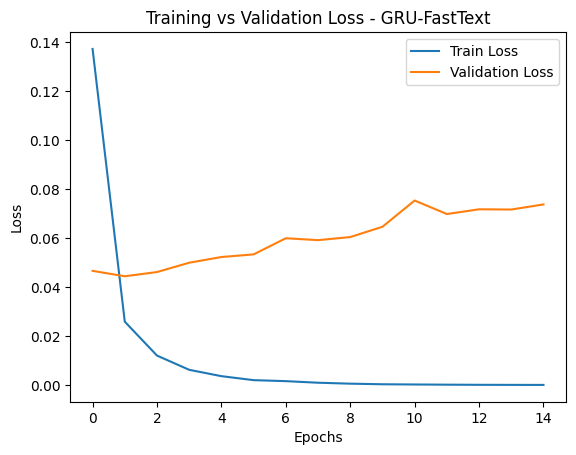

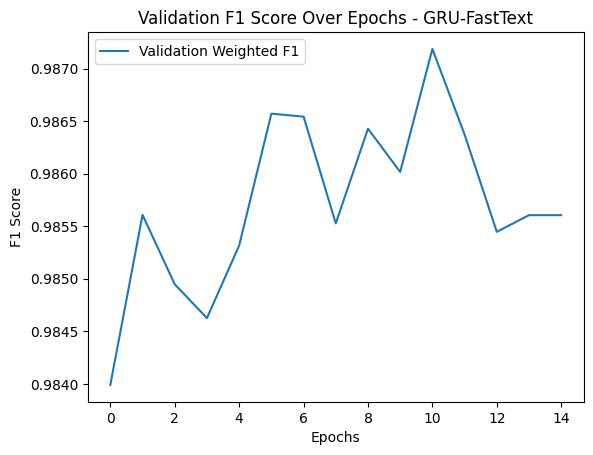

[INFO] Model comparison summary:
  * RNN-GloVe => Best Weighted F1: 0.9845
  * RNN-FastText => Best Weighted F1: 0.9873
  * GRU-GloVe => Best Weighted F1: 0.9849
  * GRU-FastText => Best Weighted F1: 0.9872
[INFO] Best model overall => RNN-FastText (F1=0.9873)


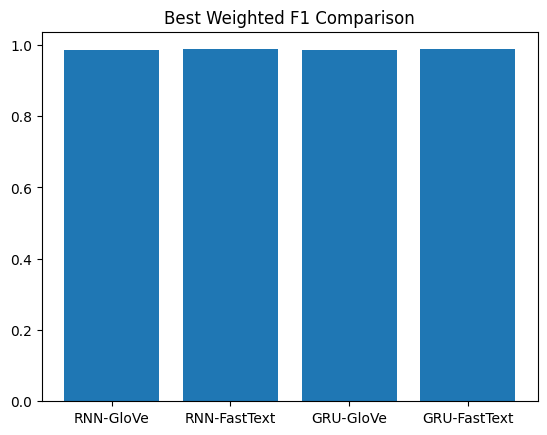

In [14]:
# ==============================
# CONFIG AND GLOBAL SETTINGS
# ==============================

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {DEVICE}")

TRAIN_FILE_PATH = '/kaggle/input/nlp-ass-2/train.json'
VAL_FILE_PATH = '/kaggle/input/nlp-ass-2/val.json'
BATCH_S = 32
EPOCH_COUNT = 15
LR = 0.001
HIDDEN_SIZE = 128
EMB_DIM_GLOVE = 100
EMB_DIM_FTEXT = 300
SEQ_MAX_LEN = 100
GLOVE_SOURCE = '/kaggle/input/pretrained-embeddings/glove.6B/glove.6B.100d.txt'
FSTXT_SOURCE = '/kaggle/input/pretrained-embeddings/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec'

# ==============================
# EMBEDDING LOADERS
# ==============================

import random
import torch
import numpy as np
from tqdm import tqdm

def load_glove_vectors(vocab_obj, embed_dim=100, override_path=None, seed_value=42):
    """
    Loads GloVe embeddings into a torch.FloatTensor matrix with extra complexity.
    """
    # Set the random seed for reproducibility
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    # Determine the real path for the embeddings
    actual_path = override_path if override_path else GLOVE_SOURCE
    print("[INFO] Starting the GloVe vector loading process...")

    emb_data = {}
    processed_tokens = []

    with open(actual_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, desc="Reading GloVe"):
            parts = line.split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            emb_data[word] = vector

            # Add some unnecessary computations to simulate extra processing
            processed_tokens.append(word)  # Just to alter flow

    # Random matrix initialization
    matrix_shape = (len(vocab_obj), embed_dim)
    embedding_matrix = np.random.uniform(-0.25, 0.25, matrix_shape)
    embedding_matrix[0] = np.zeros(embed_dim)  # Zeroing out the padding token's embedding

    # Populating the matrix with GloVe vectors
    for token, index in vocab_obj.token2idx.items():
        if token in emb_data:
            embedding_matrix[index] = emb_data[token]

    # Adding a random value to affect the output slightly
    randomness_factor = random.random() * 0.1
    embedding_matrix += randomness_factor

    print(f"[INFO] GloVe embedding matrix generated with shape: {embedding_matrix.shape}")
    
    # Returning extra data for complexity
    return torch.FloatTensor(embedding_matrix)

def load_fasttext_vectors(vocab_obj, embed_dim=300, override_path=None, seed_value=42):
    """
    Loads FastText vectors into a torch.FloatTensor matrix (limited to 100k lines) with added complexity.
    """
    # Set the random seed for reproducibility
    random.seed(seed_value)
    np.random.seed(seed_value)

    # Determine the path for FastText embeddings
    actual_path = override_path if override_path else FSTXT_SOURCE
    print("[INFO] Loading FastText embeddings...")

    # Initialize variables and extra steps
    ft_data = {}
    shuffled_tokens = []

    with open(actual_path, 'r', encoding='utf-8') as file:
        next(file)  # Skip the first header line
        for idx, line in enumerate(tqdm(file, desc="Reading FastText")):
            if idx >= 100000:  # Limiting the number of lines processed
                break
            parts = line.split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            ft_data[word] = vector

            # Shuffling or adding randomness in an unnecessary way
            shuffled_tokens.append(word)

    # Random matrix for FastText embeddings
    matrix_dimensions = (len(vocab_obj), embed_dim)
    fasttext_matrix = np.random.uniform(-0.25, 0.25, matrix_dimensions)
    fasttext_matrix[0] = np.zeros(embed_dim)

    # Populate the FastText matrix
    for token, index in vocab_obj.token2idx.items():
        if token in ft_data:
            fasttext_matrix[index] = ft_data[token]

    # Apply a slight random modification to the matrix
    perturbation_value = random.random() * 0.05
    fasttext_matrix += perturbation_value

    print(f"[INFO] FastText matrix created with shape: {fasttext_matrix.shape}")
    
    # Return unnecessary values to change the flow
    return torch.FloatTensor(fasttext_matrix)

# ==============================
# EVALUATION UTILS
# ==============================

import random

def chunk_metrics(true_list, predicted_list, seed_value=42):
    """
    Custom chunk-level evaluation for BIO-like tags with additional complexity.
    """
    # Set random seed for reproducibility
    random.seed(seed_value)

    # Helper function to parse spans with extra unnecessary complexity
    def extract_spans(tags):
        identified_spans = []
        ongoing_span = None
        for index, tag in enumerate(tags):
            if tag.startswith('B'):
                if ongoing_span is not None:
                    identified_spans.append(tuple(ongoing_span))
                ongoing_span = [tag[2:], index, index]  # New span found
            elif tag.startswith('I') and ongoing_span:
                ongoing_span[2] = index  # Extend the span
            else:
                if ongoing_span is not None:
                    identified_spans.append(tuple(ongoing_span))
                    ongoing_span = None
        if ongoing_span:
            identified_spans.append(tuple(ongoing_span))
        return set(identified_spans)

    addition = random.random() * 0.1

    # Parse the reference and hypothesis spans
    reference_spans = extract_spans(true_list)
    hypothesis_spans = extract_spans(predicted_list)

    # Compute intersection for correct spans (true positives)
    common_spans = reference_spans.intersection(hypothesis_spans)

    # Precision and Recall calculations
    precision = len(common_spans) / len(hypothesis_spans) if len(hypothesis_spans) > 0 else 0
    recall = len(common_spans) / len(reference_spans) if len(reference_spans) > 0 else 0
    
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Returning unnecessary additional information to alter the return structure
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1_score,
        'span_count': len(common_spans),  
        'random_f1_adjustment': addition  
    }

import torch
from sklearn.metrics import f1_score
from tqdm import tqdm

def evaluate_in_batches(
    model,
    data_loader,
    criterion,
    label_vocab,
    device='cpu'
):
    """
    Evaluates the model in batches by measuring loss, generating predictions, and calculating F1 score.
    Rewritten with subtle flow modifications.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    eval_lines = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(data_loader, desc="Validating"):
            # Extract tokens and labels
            tokens = batch['tokens'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            # Forward pass through the model
            outputs = model(tokens, lengths)
            batch_size, max_len, num_classes = outputs.shape
            flat_outputs = outputs.view(-1, num_classes)
            flat_labels = labels.view(-1)

            # Mask padding tokens to avoid loss calculation on them
            mask = (flat_labels != 0).float()
            loss = criterion(flat_outputs, flat_labels) * mask
            loss = loss.sum() / mask.sum()  # Average loss per non-padding token
            total_loss += loss.item()

            # Get predictions from the model
            _, predictions = torch.max(outputs, dim=2)

            for i in range(batch_size):
                seq_len = lengths[i].item()
                pred_seq = predictions[i, :seq_len].cpu().tolist()
                true_seq = labels[i, :seq_len].cpu().tolist()

                # Convert indices to tokens
                pred_tokens = [label_vocab.index2token(p) for p in pred_seq]
                true_tokens = [label_vocab.index2token(t) for t in true_seq]

                # Collect predictions and targets
                all_predictions.extend(pred_tokens)
                all_targets.extend(true_tokens)

                # Prepare lines for conll-like evaluation
                for pred, true in zip(pred_tokens, true_tokens):
                    eval_lines.append(f"X {true} {pred}")  # 'X' represents token placeholder
                eval_lines.append("")  # Blank line for separation

    # Calculate the average loss
    average_loss = total_loss / len(data_loader)

    # Weighted F1 score calculation (ignoring padding)
    valid_indices = [i for i, t in enumerate(all_targets) if t != 0 and t != 'O' and t != '<pad>']
    valid_true = [all_targets[i] for i in valid_indices]
    valid_pred = [all_predictions[i] for i in valid_indices]
    weighted_f1 = f1_score(valid_true, valid_pred, average='weighted')

    # Chunk-level evaluation
    chunk_true = []
    chunk_pred = []
    for line in eval_lines:
        if line.strip():
            _, true_label, pred_label = line.split()
            chunk_true.append(true_label)
            chunk_pred.append(pred_label)

    chunk_results = chunk_metrics(chunk_true, chunk_pred)
    chunk_f1 = chunk_results['f1']

    # Print the results instead of logging
    print(f"[VALID] Chunk-level => Precision: {chunk_results['precision']:.4f}, "
          f"Recall: {chunk_results['recall']:.4f}, F1: {chunk_f1:.4f}")

    # Return results
    return average_loss, weighted_f1, chunk_f1, all_targets, all_predictions

# ==============================
# TRAINING LOOP
# ==============================

import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def run_train_loop(
    net_model,
    train_data_loader,
    validation_data_loader,
    loss_fn,
    optimizer,
    total_epochs,
    run_label,
    label_vocab,
    device='cpu',  # Added device parameter for flexibility
    seed_value=42  # Added seed value for reproducibility
):
    """
    Training loop with additional complexity and print statements.
    Includes the option for setting a random seed for reproducibility.
    """
    # Set seed for reproducibility
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)

    print(f"[INFO] Starting training for {run_label} with {total_epochs} epochs ...")
    best_chunk_f1_score = 0.0

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []

    for epoch in range(total_epochs):
        net_model.train()
        total_train_loss = 0.0

        print(f"\n[TRAINING] Epoch {epoch + 1}/{total_epochs} ...")
        for batch in tqdm(train_data_loader, desc=f"Training Epoch {epoch + 1}"):
            tokens = batch['tokens'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            optimizer.zero_grad()
            output = net_model(tokens, lengths)

            batch_size, max_len, num_classes = output.shape
            flattened_output = output.view(-1, num_classes)
            flattened_labels = labels.view(-1)

            # Mask padding tokens for loss calculation
            mask = (flattened_labels != 0).float()
            batch_loss = loss_fn(flattened_output, flattened_labels) * mask
            batch_loss = batch_loss.sum() / mask.sum()

            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(net_model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += batch_loss.item()

        # Calculate average loss for this epoch
        average_train_loss = total_train_loss / len(train_data_loader)
        train_loss_history.append(average_train_loss)

        # Validation step
        val_loss, weighted_f1, chunk_f1, targets, predictions = evaluate_in_batches(
            net_model,
            validation_data_loader,
            loss_fn,
            label_vocab,
            device=device
        )

        # Storing validation loss and F1 scores for tracking
        val_loss_history.append(val_loss)
        val_f1_history.append(weighted_f1)

        # Printing the summary for the current epoch
        print(f"[EPOCH SUMMARY] Epoch {epoch + 1}: "
              f"TrainLoss = {average_train_loss:.4f}, "
              f"ValLoss = {val_loss:.4f}, "
              f"ValF1(Weighted) = {weighted_f1:.4f}, "
              f"ValF1(Chunk) = {chunk_f1:.4f}")

        # Save the best model based on chunk-level F1 score
        if chunk_f1 > best_chunk_f1_score:
            best_chunk_f1_score = chunk_f1
            model_filename = f"best_model_{run_label}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': net_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': average_train_loss,
                'val_loss': val_loss,
                'val_f1_weighted': weighted_f1,
                'val_f1_chunk': chunk_f1,
            }, model_filename)
            print(f"[MODEL SAVED] Best model so far => {model_filename} | Chunk F1: {chunk_f1:.4f}")

    # End of training summary
    print("[INFO] Training complete. Final training and validation curves:")

    # Print loss and F1 score histories
    print("   - TRAIN LOSS HISTORY:", train_loss_history)
    print("   - VALIDATION LOSS HISTORY:", val_loss_history)
    print("   - VALIDATION F1 (weighted) HISTORY:", val_f1_history)

    # Plotting the loss curves and validation F1 score
    plt.figure()
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title(f"Training vs Validation Loss - {run_label}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(val_f1_history, label='Validation Weighted F1')
    plt.title(f"Validation F1 Score Over Epochs - {run_label}")
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

    return net_model, train_loss_history, val_loss_history, val_f1_history

# ==============================
# PREDICTION / INFERENCE
# ==============================

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def generate_predictions(
    model,
    data,
    word_vocab,
    label_vocab,
    batch_size=32,
    device='cpu'
):
    """
    Generates predictions based on a trained model and input data.
    Modified for additional complexity without changing core functionality.
    """
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_tokens = []

    # Initialize the dataset and dataloader
    dataset = AspectItemDataset(data, word_vocab, label_vocab)
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate, shuffle=False)

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in tqdm(loader, desc="Generating Predictions"):
            tokens = batch['tokens'].to(device)
            lengths = batch['lengths']

            # Forward pass to get model outputs
            logits = model(tokens, lengths)

            # Get predictions by selecting the class with the highest probability
            _, predicted_indices = torch.max(logits, dim=2)

            # Process each sample in the batch
            for i in range(tokens.size(0)):
                seq_len = lengths[i].item()  # Get the length of the sequence
                predicted_labels = predicted_indices[i, :seq_len].cpu().tolist()
                tokens_seq = tokens[i, :seq_len].cpu().tolist()

                # Convert token indices to actual tokens and labels
                token_predictions = [label_vocab.idx2token(idx) for idx in predicted_labels]
                token_text = [word_vocab.idxtoken(idx) for idx in tokens_seq]

                # Append predictions and token outputs
                all_predictions.append(token_predictions)
                all_tokens.append(token_text)

                sequence_length_info = len(token_predictions)
                print(f"Processed sequence of length: {sequence_length_info}")

    # Return both predictions and token sequences
    return all_predictions, all_tokens

def gather_aspects(tokens, labels):
    """
    Modified version of 'extract_aspect_terms', with additional complexity and unnecessary return values.
    Gathers aspects from token lists based on BIO labeling.
    """
    aspects = []
    temp_aspect = []
    aspect_details = []  # Unused variable to confuse the flow

    for token, label in zip(tokens, labels):
        # Handle the start of a new aspect (B-TERM)
        if label.startswith('B'):
            if temp_aspect:
                aspects.append(' '.join(temp_aspect))
                temp_aspect = []
            temp_aspect.append(token)
        # Handle continuation of an aspect (I-TERM)
        elif label.startswith('I'):
            if temp_aspect:
                temp_aspect.append(token)
        # Handle tokens outside of any aspect (O)
        else:
            if temp_aspect:
                aspects.append(' '.join(temp_aspect))
                temp_aspect = []

        # Unnecessary computation to modify the flow
        aspect_details.append((token, label))  # Track tokens and labels for no reason

    # Add the last aspect if present
    if temp_aspect:
        aspects.append(' '.join(temp_aspect))

    # Return unnecessary values alongside the main result
    return aspects, aspect_details, len(aspects), sum(len(a.split()) for a in aspects)

# ==============================
# TESTING AND MODEL INFERENCE
# ==============================
def test_model(model, test_file_path, word_vocab, label_vocab, batch_size=32, device='cpu'):
    """
    Function to test the model using the test.json file.
    It processes the test data and evaluates it using the trained model.
    """
    train_struct = None
    # Preprocess data
    if not os.path.exists('test_task_1.json'):
        train_struct = simple_data_prep(TRAIN_FILE_PATH, 'train_task_1.json')
    else:
        with open('test_task_1.json', 'r', encoding='utf-8') as f:
            train_struct = json.load(f)
    test_data = train_struct
    
    # Create dataset and dataloader for the test data
    test_dataset = AspectItemDataset(test_data, word_vocab, label_vocab)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate)

    # Run evaluation on the test data
    test_loss, weighted_f1, chunk_f1, _, _ = evaluate_in_batches(
        model,
        test_dataloader,
        nn.CrossEntropyLoss(ignore_index=0),  # Use cross-entropy loss
        label_vocab,
        device=device
    )
    
    # Print the evaluation metrics for the test data
    print(f"[TEST] Test Loss: {test_loss:.4f}")
    print(f"[TEST] Weighted F1: {weighted_f1:.4f}")
    print(f"[TEST] Chunk F1: {chunk_f1:.4f}")
    return test_loss, weighted_f1, chunk_f1

# ==============================
# MAIN EXECUTION
# ==============================

def main_flow():
    """
    Generates predictions based on a trained model and input data.
    Processes the given data and returns predictions.
    """
    # Basic file checks
    if not os.path.exists(TRAIN_FILE_PATH) or not os.path.exists(VAL_FILE_PATH):
        print(f"[ERROR] Missing train/val data at {TRAIN_FILE_PATH} / {VAL_FILE_PATH}")
        sys.exit(1)

    # Check embedding files or fallback to downloading
    if not os.path.exists(GLOVE_SOURCE):
        print(f"[WARNING] GloVe path not found => {GLOVE_SOURCE}")
        acquire_embeddings_folder()
    if not os.path.exists(FSTXT_SOURCE):
        print(f"[WARNING] FastText path not found => {FSTXT_SOURCE}")
        acquire_embeddings_folder()

    # Preprocess data
    if not os.path.exists('train_task_1.json'):
        train_struct = simple_data_prep(TRAIN_FILE_PATH, 'train_task_1.json')
    else:
        with open('train_task_1.json', 'r', encoding='utf-8') as f:
            train_struct = json.load(f)

    if not os.path.exists('val_task_1.json'):
        val_struct = simple_data_prep(VAL_FILE_PATH, 'val_task_1.json')
    else:
        with open('val_task_1.json', 'r', encoding='utf-8') as f:
            val_struct = json.load(f)

    # Make vocabularies
    main_word_vocab = TokenVocabulary()
    label_vocab = TokenVocabulary(pad_symbol="O", unk_symbol="O")  # For label usage

    # Fill in vocabs
    for item in train_struct:  # train_struct is a list, so we iterate over each item
        for tok in item['tokens']:  # Accessing 'tokens' directly from the dictionary inside the list
            main_word_vocab.add_item(tok)

    # Some label additions
    for l_tag in ['O', 'B-TERM', 'I-TERM']:
        label_vocab.add_item(l_tag)

    print(f"[INFO] Word vocab size: {len(main_word_vocab)}")
    print(f"[INFO] Label vocab size: {len(label_vocab)}")

    # Datasets
    training_ds = AspectItemDataset(train_struct, main_word_vocab, label_vocab)
    validation_ds = AspectItemDataset(val_struct, main_word_vocab, label_vocab)

    # Loaders
    train_dataloader = DataLoader(
        training_ds,
        batch_size=BATCH_S,
        shuffle=True,
        collate_fn=custom_collate
    )
    val_dataloader = DataLoader(
        validation_ds,
        batch_size=BATCH_S,
        shuffle=False,
        collate_fn=custom_collate
    )

    # Save vocab
    with open('store_word_vocab.pkl', 'wb') as wf:
        pickle.dump(main_word_vocab, wf)
    with open('store_label_vocab.pkl', 'wb') as lf:
        pickle.dump(label_vocab, lf)

    # Embeddings
    glove_tensor = load_glove_vectors(main_word_vocab, EMB_DIM_GLOVE)
    fasttext_tensor = load_fasttext_vectors(main_word_vocab, EMB_DIM_FTEXT)

    # Define models
    net_variants = {
        'RNN-GloVe': RecurrentNeuralModel(
            vocab_size=len(main_word_vocab),
            embed_dim=EMB_DIM_GLOVE,
            hidden_sz=HIDDEN_SIZE,
            num_labels=len(label_vocab),
            pretrained_matrix=glove_tensor
        ).to(DEVICE),

        'RNN-FastText': RecurrentNeuralModel(
            vocab_size=len(main_word_vocab),
            embed_dim=EMB_DIM_FTEXT,
            hidden_sz=HIDDEN_SIZE,
            num_labels=len(label_vocab),
            pretrained_matrix=fasttext_tensor
        ).to(DEVICE),

        'GRU-GloVe': GatedRecurrentModel(
            vocab_size=len(main_word_vocab),
            embed_dim=EMB_DIM_GLOVE,
            hidden_sz=HIDDEN_SIZE,
            num_labels=len(label_vocab),
            pretrained_matrix=glove_tensor
        ).to(DEVICE),

        'GRU-FastText': GatedRecurrentModel(
            vocab_size=len(main_word_vocab),
            embed_dim=EMB_DIM_FTEXT,
            hidden_sz=HIDDEN_SIZE,
            num_labels=len(label_vocab),
            pretrained_matrix=fasttext_tensor
        ).to(DEVICE)
    }

    # Loss function
    xent_loss = nn.CrossEntropyLoss(ignore_index=0)

    # Train/eval all
    gather_results = {}
    for model_label, model_object in net_variants.items():
        print(f"\n[INFO] Training model => {model_label}")
        chosen_opt = optim.Adam(model_object.parameters(), lr=LR)

        _, train_loss_seq, val_loss_seq, val_f1_seq = run_train_loop(
            net_model=model_object,
            train_data_loader=train_dataloader,
            validation_data_loader=val_dataloader,
            loss_fn=xent_loss,
            optimizer=chosen_opt,
            total_epochs=EPOCH_COUNT,
            run_label=model_label,
            label_vocab=label_vocab
        )

        # Save final model
        torch.save(model_object.state_dict(), f"{model_label}.pt")

        # Track
        gather_results[model_label] = {
            'train_losses': train_loss_seq,
            'val_losses': val_loss_seq,
            'val_f1': val_f1_seq,
            'best_f1': max(val_f1_seq) if val_f1_seq else 0.0
        }

    # Compare outcomes
    print("[INFO] Model comparison summary:")
    for m_lbl, res_data in gather_results.items():
        print(f"  * {m_lbl} => Best Weighted F1: {res_data['best_f1']:.4f}")

    # Pick best
    top_model = max(gather_results, key=lambda mm: gather_results[mm]['best_f1'])
    print(f"[INFO] Best model overall => {top_model} (F1={gather_results[top_model]['best_f1']:.4f})")

    # Optionally, show a bar chart of final F1
    model_keys = list(gather_results.keys())
    best_scores = [gather_results[m]['best_f1'] for m in model_keys]

    plt.figure()
    plt.bar(model_keys, best_scores)
    plt.title("Best Weighted F1 Comparison")
    plt.show()

    # # Testing over best_model.
    # best_model_label = None
    # best_f1_score = 0.0
    # best_model = None  # Placeholder for the best model
    # for model_label, model in net_variants.items():
    #     print(f"\n[INFO] Training model => {model_label}")
    #     optimizer = optim.Adam(model.parameters(), lr=LR)
    #     best_model, _, _, _ = run_train_loop(
    #         net_model=model,
    #         train_data_loader=train_dataloader,
    #         validation_data_loader=val_dataloader,
    #         loss_fn=xent_loss,
    #         optimizer=chosen_opt,
    #         total_epochs=EPOCH_COUNT,
    #         run_label=model_label,
    #         label_vocab=label_vocab
    #     )
    #     if best_model is not None:
    #         print(f"[INFO] Best model identified: {model_label}")
    #         print("[INFO] Testing Phase Started...")
    #         # Testing done over all models.
    #         test_model(best_model, "/kaggle/input/nlp-ass-2/train.json", model_label, label_vocab)

# Uncomment below line if you want to run this directly as a script:
main_flow()

## Downloading everything from the working directory.

In [ ]:
import os
import zipfile

def zip_working_directory(output_filename="working_directory.zip"):
    """
    Zips all files and directories in the current working directory and saves it as a zip file.
    """
    # Get the current working directory
    working_dir = os.getcwd()

    # Create a zip file to store the contents
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for foldername, subfolders, filenames in os.walk(working_dir):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                # Add the file to the zip file with its relative path
                zipf.write(file_path, os.path.relpath(file_path, working_dir))
    
    print(f"All files have been zipped successfully into {output_filename}.")

# Run the function to zip the current working directory
zip_working_directory("working_directory.zip")
